# Experiment for scalability

### Fetch Data from Adult income dataset

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML

import shap
shap.initjs()

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

X, Y = shap.datasets.adult()
sensitive_attribute = 'Sex'

A = X[sensitive_attribute]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

X = X.reset_index(drop=True)
A = A.reset_index(drop=True)

X_train = pd.DataFrame(X)
A_train = pd.Series(A)
y_train = pd.Series(Y)

# Combine all training data into a single data frame and glance at a few rows
all_train = pd.concat([X_train, y_train, A_train], axis=1)

# Keep the complete dataset for grid search
X_train_all = X_train
y_train_all = y_train
A_train_all = A_train

# Subsampling process
subsampling = all_train.sample(frac=0.3)
subsampling = subsampling.reset_index()
subsampling = subsampling.drop(columns=['index'])
tmp = subsampling.iloc[:, :-1]
A_train = subsampling.iloc[:, -1]
X_train = tmp.iloc[:, :-1]
y_train = tmp.iloc[:,-1]
all_train = pd.concat([X_train, y_train, A_train], axis=1)

display(all_train)


Bad key "text.kerning_factor" on line 4 in
/Users/parulgupta/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,0,Sex
0,34.0,4,9.0,4,7,1,2,0,0.0,0.0,40.0,39,0,0
1,49.0,7,7.0,2,1,4,4,1,0.0,0.0,40.0,39,0,1
2,37.0,4,9.0,0,8,0,4,1,0.0,0.0,40.0,39,0,1
3,48.0,4,13.0,2,10,4,4,1,15024.0,0.0,45.0,39,1,1
4,36.0,4,8.0,4,14,0,1,1,0.0,0.0,45.0,0,0,1
5,37.0,4,9.0,3,5,1,3,1,0.0,0.0,40.0,26,0,1
6,30.0,0,13.0,2,0,5,4,0,0.0,0.0,20.0,39,0,0
7,21.0,7,12.0,4,13,3,4,1,0.0,0.0,10.0,39,0,1
8,21.0,4,10.0,4,12,3,4,1,0.0,0.0,40.0,39,0,1
9,55.0,4,10.0,4,1,3,4,0,0.0,0.0,36.0,39,0,0


### Unmitigated Learner - Logistic Regression and Gradient Boosting

In [2]:
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

from sklearn.ensemble import GradientBoostingClassifier
ensemble_learner = GradientBoostingClassifier()
ensemble_learner.fit(X_train_all,y_train_all)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [3]:
from fairlearn.reductions import EqualizedOdds, ErrorRate

def UnmitLogistic(X): return logistic_learner.predict(X)
# violation
disparity_moment = EqualizedOdds()
disparity_moment.load_data(X, Y, sensitive_features=A)
log_violation_unmitigated = disparity_moment.gamma(UnmitLogistic).max()

# error
error = ErrorRate()
error.load_data(X, Y, sensitive_features=A)
log_error_unmitigated = error.gamma(UnmitLogistic)[0]

print('Logistic Regression - Violation: {} and Error: {}'.format(log_violation_unmitigated, log_error_unmitigated))

def UnmitGradBoost(X): return ensemble_learner.predict(X)
# violation
disparity_moment = EqualizedOdds()
disparity_moment.load_data(X, Y, sensitive_features=A)
grad_violation_unmitigated = disparity_moment.gamma(UnmitGradBoost).max()

# error
error = ErrorRate()
error.load_data(X, Y, sensitive_features=A)
grad_error_unmitigated = error.gamma(UnmitGradBoost)[0]

print('Grad Boost - Violation: {} and Error: {}'.format(grad_violation_unmitigated, grad_error_unmitigated))

Logistic Regression - Violation: 0.15237168667902207 and Error: 0.1586253493443076
Grad Boost - Violation: 0.08262975579420462 and Error: 0.13064709314824483


### Exponentiated Gradient on subsample of the dataset - Logistic Regression and Gradient Boosting

In [4]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np

expgrad_error_logistic = []
expgrad_violation_logistic = []

expgrad_error_ensemble = []
expgrad_violation_ensemble = []

eps_list = [0.01]

for eps in eps_list:
    # Definition of expgrad for logistic learner
    expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    # Definition of expgrad for gradient boosting
    expgrad_X_ensemble = ExponentiatedGradient(
    GradientBoostingClassifier(),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    
    a=datetime.now()  
    expgrad_X_logistic.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    b=datetime.now()
    log_time_expgrad = (b-a).seconds
    
    a=datetime.now()  
    expgrad_X_ensemble.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    b=datetime.now()
    grad_time_expgrad = (b-a).seconds
    
    def Qlog(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    log_violation_expgrad = disparity_moment.gamma(Qlog).max()
    
    # error of log res
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    log_error_expgrad = error.gamma(Qlog)[0]
    
    def Qgrad(X): return expgrad_X_ensemble._pmf_predict(X)[:, 1]
    # violation of grad boost
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    grad_violation_expgrad = disparity_moment.gamma(Qgrad).max()
    
    # error of grad boost
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    grad_error_expgrad = error.gamma(Qgrad)[0]

In [5]:
print("Logistic learner - error & violation:")
print(log_error_expgrad, log_violation_expgrad)
print("Gradient boosting learner - error & violation:")
print(grad_error_expgrad, grad_violation_expgrad)

Logistic learner - error & violation:
0.17644678938412525 0.008095941751148333
Gradient boosting learner - error & violation:
0.14890641542757785 0.005738785478501901


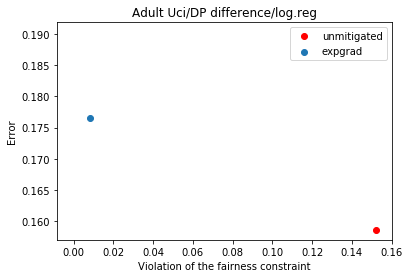

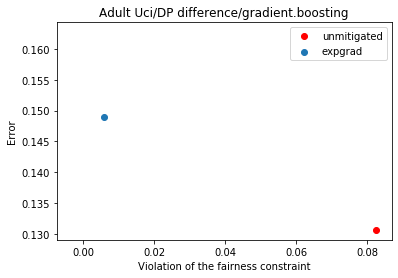

In [6]:
import matplotlib.pyplot as plt

plt.scatter(log_violation_expgrad,log_error_expgrad,label="expgrad")
plt.plot(log_violation_unmitigated, log_error_unmitigated,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

plt.scatter(grad_violation_expgrad, grad_error_expgrad,label="expgrad")
plt.plot(grad_violation_unmitigated, grad_error_unmitigated,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()

# Grid Search for Logistic Learner

### Using langrangian lambda derived from exponentiated gradient on complete dataset and predicting the value using predict from grid search

In [7]:
lambda_vecs_logistic = expgrad_X_logistic._lambda_vecs_lagrangian

In [8]:
grid_search_logistic=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=lambda_vecs_logistic)
a=datetime.now()
grid_search_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
log_time_grid_search = (b-a).seconds

In [9]:
def Qlog(X): return grid_search_logistic.predict(X)
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_violation_grid_search = disparity_moment.gamma(Qlog).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_grid_search = error.gamma(Qlog)[0]

In [10]:
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Unmit.', log_violation_unmitigated, log_error_unmitigated))
print('{}\t\t{}\t{}'.format('Expgrad', log_violation_expgrad, log_error_expgrad))
print('{}\t{}\t{}'.format('Grid Search', log_violation_grid_search, log_error_grid_search))

Type		Violation		Error
Unmit.		0.15237168667902207	0.1586253493443076
Expgrad		0.008095941751148333	0.17644678938412525
Grid Search	0.005184672544976482	0.17637664690887872


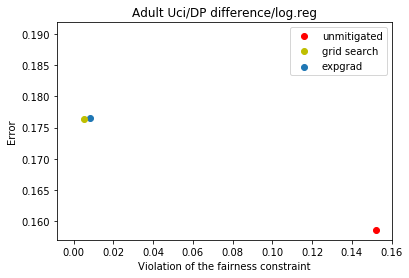

In [11]:
plt.scatter(log_violation_expgrad, log_error_expgrad, label="expgrad")
plt.plot(log_violation_unmitigated, log_error_unmitigated,'ro',label="unmitigated")
plt.plot(log_violation_grid_search, log_error_grid_search,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

Type		Violation		Error
Grid Search	0.12424042105058944	0.1586253493443076
Grid Search	0.06694786478636096	0.16700961272688186
Grid Search	0.6692054912318417	0.49918614293172814
Grid Search	0.05249373029257233	0.16547403335278402
Grid Search	0.35207207026161114	0.32677129080802186
Grid Search	0.1041455821515419	0.21280058966247967
Grid Search	0.005184672544976482	0.17637664690887872
Grid Search	0.6014242135864054	0.4475599643745585
Selected GS	0.005184672544976482	0.17637664690887872
Exp.		0.008095941751148333	0.17644678938412525
Unmit.		0.15237168667902207	0.1586253493443076


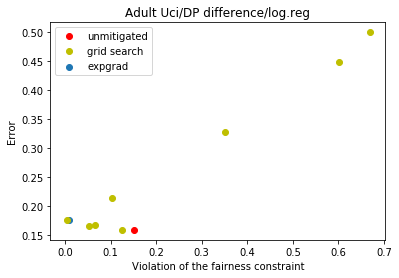

In [12]:
#all grid search predictors
predictors = grid_search_logistic._predictors

log_errors_all_gs = []
log_violation_all_gs = []
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
for i in predictors:
    def Qlog(X): return i.predict(X)
    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    e = error.gamma(Qlog)[0]
    log_errors_all_gs.append(e)

    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    v = disparity_moment.gamma(Qlog).max()
    log_violation_all_gs.append(v)
    
    print('{}\t{}\t{}'.format('Grid Search', v, e))
    
print('{}\t{}\t{}'.format('Selected GS', log_violation_grid_search, log_error_grid_search))
print('{}\t\t{}\t{}'.format('Exp.',log_violation_expgrad, log_error_expgrad))
print('{}\t\t{}\t{}'.format('Unmit.',log_violation_unmitigated, log_error_unmitigated))

plt.plot(log_violation_unmitigated, log_error_unmitigated,'ro',label="unmitigated")
plt.plot(log_violation_all_gs, log_errors_all_gs,'yo',label="grid search")
plt.scatter(log_violation_expgrad, log_error_expgrad, label="expgrad")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

### Using langrangian lambda derived from exponentiated gradient on complete dataset and predicting the averaged error using pmf_predict

In [13]:
grid_search_logistic=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=lambda_vecs_logistic)
a=datetime.now()
grid_search_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
log_time_grid_search_pmf = (b-a).seconds

In [14]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [15]:
predictors = grid_search_logistic._predictors
weights_logistic = expgrad_X_logistic._weights

def Qlog(X): return _pmf_predict(X, predictors, weights_logistic)[:,1]
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_violation_grid_search_pmf = disparity_moment.gamma(Qlog).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_grid_search_pmf = error.gamma(Qlog)[0]

In [16]:
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Unmit.', log_violation_unmitigated, log_error_unmitigated))
print('{}\t\t{}\t{}'.format('Exp.', log_violation_expgrad, log_error_expgrad))
print('{}\t{}\t{}'.format('Grid Search pmf', log_violation_grid_search_pmf, log_error_grid_search_pmf))

Type		Violation		Error
Unmit.		0.15237168667902207	0.1586253493443076
Exp.		0.008095941751148333	0.17644678938412525
Grid Search pmf	0.011649459710013133	0.1748868037469443


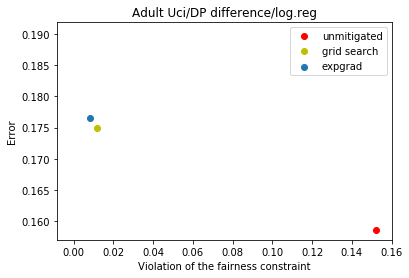

In [17]:
plt.scatter(log_violation_expgrad, log_error_expgrad, label="expgrad")
plt.plot(log_violation_unmitigated, log_error_unmitigated,'ro',label="unmitigated")
plt.plot(log_violation_grid_search_pmf, log_error_grid_search_pmf,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

# Grid Search for Gradient Boosting

### Using langrangian lambda derived from exponentiated gradient on complete dataset and predicting the value using predict from grid search

In [18]:
lambda_vecs_ensemble = expgrad_X_ensemble._lambda_vecs_lagrangian

In [19]:
grid_search_ensemble=GridSearch(GradientBoostingClassifier(),
                        constraints=DemographicParity(),
                        grid=lambda_vecs_ensemble)
a=datetime.now()
grid_search_ensemble.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
grad_time_grid_search = (b-a).seconds

In [20]:
def Qgrad(X): return grid_search_ensemble.predict(X)
# violation of grad
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
grad_violation_grid_search = disparity_moment.gamma(Qlog).max()

# error of grad
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
grad_error_grid_search = error.gamma(Qlog)[0]

In [21]:
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Unmit.', grad_violation_unmitigated, grad_error_unmitigated))
print('{}\t\t{}\t{}'.format('Expgrad', grad_violation_expgrad, grad_error_expgrad))
print('{}\t{}\t{}'.format('Grid Search', grad_violation_grid_search, grad_error_grid_search))

Type		Violation		Error
Unmit.		0.08262975579420462	0.13064709314824483
Expgrad		0.005738785478501901	0.14890641542757785
Grid Search	0.011649459710013133	0.1748868037469443


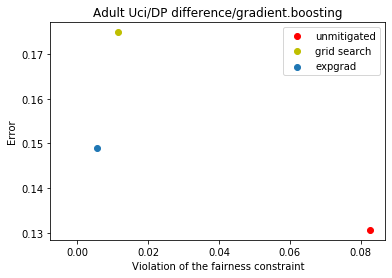

In [22]:
plt.scatter(grad_violation_expgrad, grad_error_expgrad,label="expgrad")
plt.plot(grad_violation_unmitigated, grad_error_unmitigated,'ro',label="unmitigated")
plt.plot(grad_violation_grid_search, grad_error_grid_search,'yo',label="grid search")

plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()

Type		Violation		Error
Grid Search	0.11763440734082388	0.13064709314824483
Grid Search	0.07544660018663442	0.13258192315960812
Grid Search	0.0973784031777115	0.130524246798317
Grid Search	0.6692054912318417	0.49918614293172814
Grid Search	0.047338842655481536	0.13660514111974448
Grid Search	0.5829673535825066	0.4241884463007893
Grid Search	0.02923396692679381	0.14111974447959216
Grid Search	0.06761787694505306	0.1338103866588864
Grid Search	0.1338840619637742	0.2052762507294002
Grid Search	0.010521930726617085	0.1464328491139707
Grid Search	0.03656486648396101	0.16304781794170942
Grid Search	0.0020632478441561797	0.151223856761156
Grid Search	0.6123276312152575	0.44347532323945826
Selected GS	0.011649459710013133	0.1748868037469443
Exp.		0.005738785478501901	0.14890641542757785
Unmit.		0.08262975579420462	0.13064709314824483


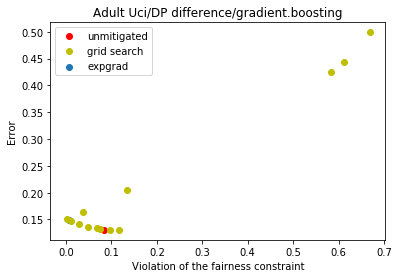

In [23]:
#all grid search predictors
predictors = grid_search_ensemble._predictors

grad_errors_all_gs = []
grad_violation_all_gs = []
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
for i in predictors:
    def Qlog(X): return i.predict(X)
    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    e = error.gamma(Qlog)[0]
    grad_errors_all_gs.append(e)

    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    v = disparity_moment.gamma(Qlog).max()
    grad_violation_all_gs.append(v)
    
    print('{}\t{}\t{}'.format('Grid Search', v, e))
    
print('{}\t{}\t{}'.format('Selected GS', grad_violation_grid_search, grad_error_grid_search))
print('{}\t\t{}\t{}'.format('Exp.',grad_violation_expgrad, grad_error_expgrad))
print('{}\t\t{}\t{}'.format('Unmit.',grad_violation_unmitigated, grad_error_unmitigated))

plt.plot(grad_violation_unmitigated, grad_error_unmitigated,'ro',label="unmitigated")
plt.plot(grad_violation_all_gs, grad_errors_all_gs,'yo',label="grid search")
plt.scatter(grad_violation_expgrad, grad_error_expgrad, label="expgrad")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()

### Using langrangian lambda derived from exponentiated gradient on complete dataset and predicting the averaged error using pmf_predict

In [24]:
grid_search_ensemble=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=lambda_vecs_ensemble)
a=datetime.now()
grid_search_ensemble.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
grad_time_grid_search_pmf = (b-a).seconds

In [25]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [26]:
predictors = grid_search_ensemble._predictors
weights_ensemble = expgrad_X_ensemble._weights

def Qgrad(X): return _pmf_predict(X, predictors, weights_ensemble)[:,1]
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
grad_violation_grid_search_pmf = disparity_moment.gamma(Qgrad).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
grad_error_grid_search_pmf = error.gamma(Qgrad)[0]

In [27]:
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Unmit.', grad_violation_unmitigated, grad_error_unmitigated))
print('{}\t\t{}\t{}'.format('Exp.', grad_violation_expgrad, grad_error_expgrad))
print('{}\t{}\t{}'.format('Grid Search pmf', grad_violation_grid_search_pmf, grad_error_grid_search_pmf))

Type		Violation		Error
Unmit.		0.08262975579420462	0.13064709314824483
Exp.		0.005738785478501901	0.14890641542757785
Grid Search pmf	0.028484933346123342	0.18645112761933852


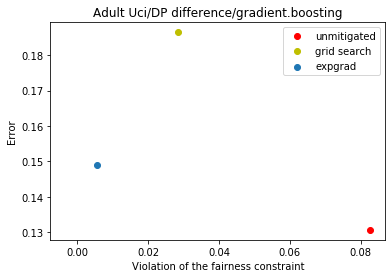

In [28]:
plt.scatter(grad_violation_expgrad, grad_error_expgrad, label="expgrad")
plt.plot(grad_violation_unmitigated, grad_error_unmitigated,'ro',label="unmitigated")
plt.plot(grad_violation_grid_search_pmf, grad_error_grid_search_pmf,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()

# Running Time Analysis

### Run exponential gradient on complete dataset

In [29]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np

expgrad_error_logistic = []
expgrad_violation_logistic = []

expgrad_error_ensemble = []
expgrad_violation_ensemble = []

eps_list = [0.01]

for eps in eps_list:
    # Definition of expgrad for logistic learner
    expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    # Definition of expgrad for gradient boosting
    expgrad_X_ensemble = ExponentiatedGradient(
    GradientBoostingClassifier(),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    
    a=datetime.now()  
    expgrad_X_logistic.fit(
    X_train_all,
    y_train_all,
    sensitive_features=A_train_all)
    b=datetime.now()
    log_time_expgrad_all = (b-a).seconds
    
    a=datetime.now()  
    expgrad_X_ensemble.fit(
    X_train_all,
    y_train_all,
    sensitive_features=A_train_all)
    b=datetime.now()
    grad_time_expgrad_all = (b-a).seconds
    
    def Qlog(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    log_violation_expgrad_all = disparity_moment.gamma(Qlog).max()
    
    # error of log res
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    log_error_expgrad_all = error.gamma(Qlog)[0]
    
    def Qgrad(X): return expgrad_X_ensemble._pmf_predict(X)[:, 1]
    # violation of grad boost
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    grad_violation_expgrad_all = disparity_moment.gamma(Qgrad).max()
    
    # error of grad boost
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    grad_error_expgrad_all = error.gamma(Qgrad)[0]

### Results

In [30]:
print("Exponential Gradient on complete dataset")
print("Logistic Learner time: {}".format(log_time_expgrad_all))
print("Grad boosting learner time: {}".format(grad_time_expgrad_all))
print("")
print("Scaling method:")
print("Logistic Learner")
print("Time for Expgrad: {}".format(log_time_expgrad))
print("Time for Grid Search: {}".format(log_time_grid_search))
print("Combined time: {}".format(log_time_expgrad + log_time_grid_search))
print("Grad boosting learner")
print("Time for Expgrad: {}".format(grad_time_expgrad))
print("Time for Grid Search: {}".format(grad_time_grid_search))
print("Combined time: {}".format(grad_time_expgrad + grad_time_grid_search))

Exponential Gradient on complete dataset
Logistic Learner time: 62
Grad boosting learner time: 69

Scaling method:
Logistic Learner
Time for Expgrad: 13
Time for Grid Search: 18
Combined time: 31
Grad boosting learner
Time for Expgrad: 20
Time for Grid Search: 46
Combined time: 66


# Error/Violation Analysis

In [31]:
print("Exponential Gradient on complete dataset")
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print("{}\t{}\t{}".format('Logistic', log_violation_expgrad_all, log_error_expgrad_all))
print("{}\t{}\t{}".format('Grad boosting', grad_violation_expgrad_all, grad_error_expgrad_all))
print("")
print("Scaling method:")
print("Logistic Learner")
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Exp.', log_violation_expgrad, log_error_expgrad))
print('{}\t{}\t{}'.format('Selected GS', log_violation_grid_search, log_error_grid_search))
print('{}\t{}\t{}'.format('Grid Search pmf', log_violation_grid_search_pmf, log_error_grid_search_pmf))
print("")
print("Grad boosting learner")
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Exp.',grad_violation_expgrad, grad_error_expgrad))
print('{}\t{}\t{}'.format('Selected GS', grad_violation_grid_search, grad_error_grid_search))
print('{}\t{}\t{}'.format('Grid Search pmf', grad_violation_grid_search_pmf, grad_error_grid_search_pmf))

Exponential Gradient on complete dataset
Type		Violation		Error
Logistic	0.009999999999999842	0.17500405838194907
Grad boosting	0.009999999999999787	0.14616398371964864

Scaling method:
Logistic Learner
Type		Violation		Error
Exp.		0.008095941751148333	0.17644678938412525
Selected GS	0.005184672544976482	0.17637664690887872
Grid Search pmf	0.011649459710013133	0.1748868037469443

Grad boosting learner
Type		Violation		Error
Exp.		0.005738785478501901	0.14890641542757785
Selected GS	0.011649459710013133	0.1748868037469443
Grid Search pmf	0.028484933346123342	0.18645112761933852
